Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 56s 69ms/step - loss: 0.0137 - mae: 0.0789 - val_loss: 0.0062 - val_mae: 0.0507
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 54s 70ms/step - loss: 0.0062 - mae: 0.0508 - val_loss: 0.0063 - val_mae: 0.0518
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 53s 68ms/step - loss: 0.0061 - mae: 0.0499 - val_loss: 0.0062 - val_mae: 0.0502
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 53s 67ms/step - loss: 0.0060 - mae: 0.0492 - val_loss: 0.0057 - val_mae: 0.0480
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 55s 71ms/step - loss: 0.0058 - mae: 0.0485 - val_loss: 0.0056 - val_mae: 0.0477


Model saved at models/colorization_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


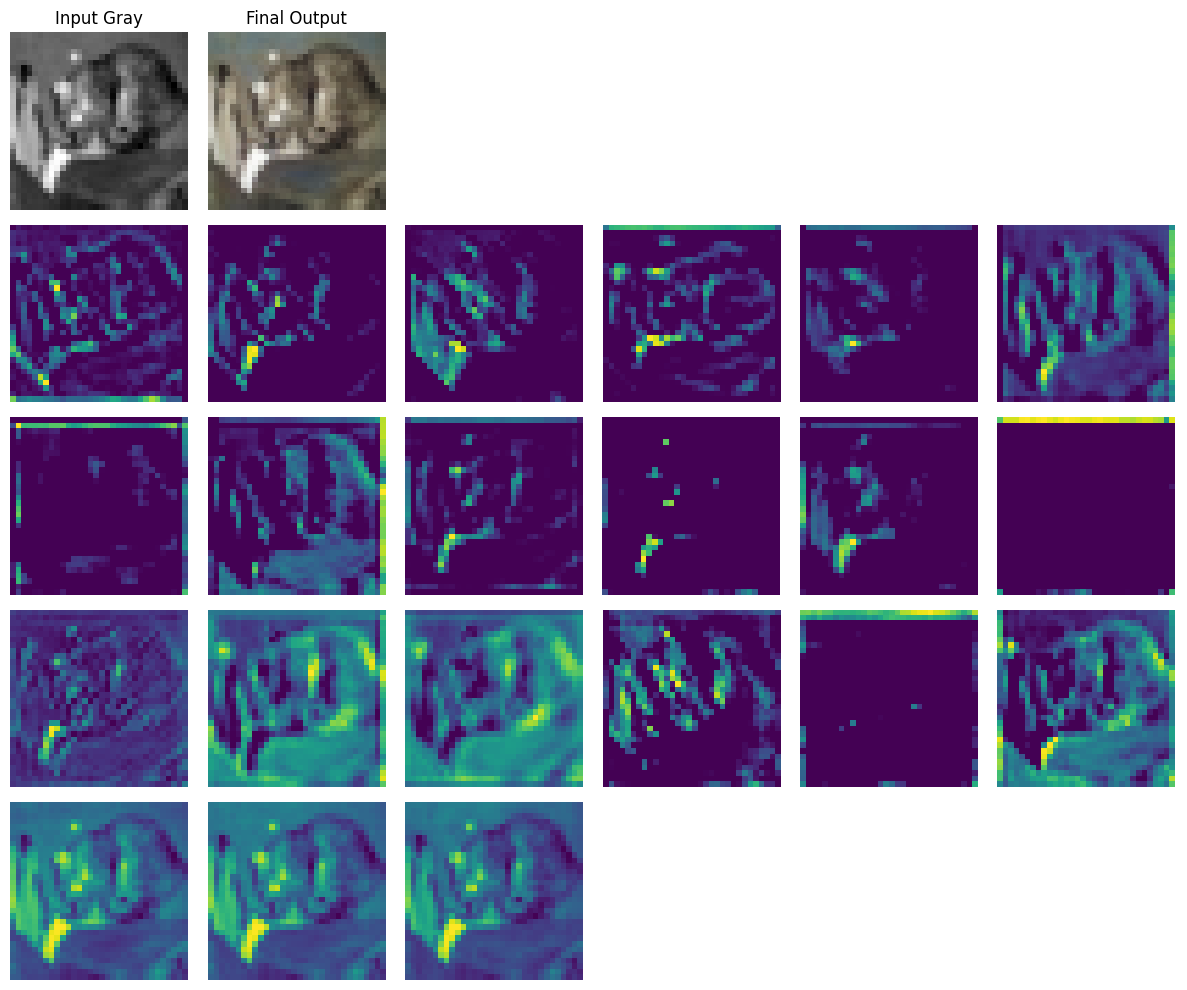

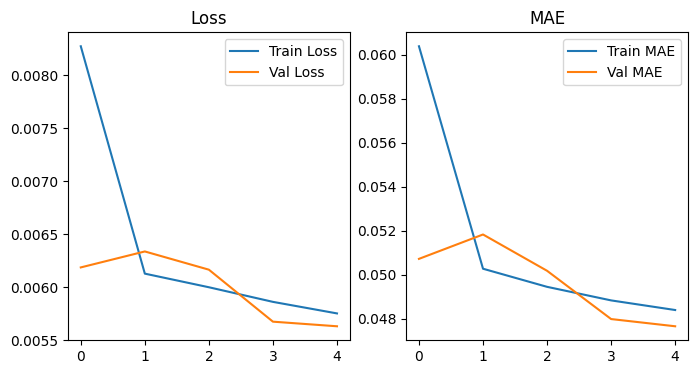

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import os

# Load CIFAR-10
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert to grayscale for input
x_train_gray = tf.image.rgb_to_grayscale(x_train).numpy()
x_test_gray = tf.image.rgb_to_grayscale(x_test).numpy()

# Model
inputs = layers.Input(shape=(32, 32, 1))
c1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
c2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c1)
c3 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c2)
outputs = layers.Conv2D(3, (3,3), activation='sigmoid', padding='same')(c3)
model = models.Model(inputs, outputs)

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train with logs
history = model.fit(
    x_train_gray, x_train,
    validation_data=(x_test_gray, x_test),
    epochs=5,
    batch_size=64,
    verbose=1
)

# Save model
os.makedirs("models", exist_ok=True)
model.save("models/colorization_model.h5")
print("Model saved at models/colorization_model.h5")

# Visualize intermediate layers
layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
sample_gray = x_test_gray[:1]
activations = activation_model.predict(sample_gray)

fig, axes = plt.subplots(len(activations)+1, 6, figsize=(12, 2*(len(activations)+1)))
axes[0,0].imshow(sample_gray[0].squeeze(), cmap='gray')
axes[0,0].set_title("Input Gray")
axes[0,0].axis('off')
axes[0,1].imshow(model.predict(sample_gray)[0])
axes[0,1].set_title("Final Output")
axes[0,1].axis('off')
for ax in axes[0,2:]:
    ax.axis('off')

for i, activation in enumerate(activations):
    for j in range(6):
        if j < activation.shape[-1]:
            axes[i+1,j].imshow(activation[0,:,:,j], cmap='viridis')
        axes[i+1,j].axis('off')
plt.tight_layout()
plt.show()

# Plot metrics
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.legend()
plt.title('MAE')
plt.show()
